In [5]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
!git clone https://github.com/AmrMKayid/nam.git
%cd 'nam'
!pip install -e .


In [72]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pytorch_lightning as pl
from pytorch_lightning import Trainer

from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import pandas as pd
import numpy as np

from nam.config import defaults
from nam.data import FoldedDataset
from nam.data import NAMDataset
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams
from nam.data import load_gallup_data, load_housing_data, load_sklearn_housing_data, load_breast_data
from typing import Dict

In [73]:
!cd ..

In [ ]:
config = defaults()
print(config)

X_train = pd.read_csv('data/processed_data/X_train_processed.csv')
y_train = pd.read_csv('data/processed_data/y_train_processed.csv')['HeartDisease']
X_test = pd.read_csv('data/processed_data/X_test_processed.csv')
y_test = pd.read_csv('data/processed_data/y_test.csv')['HeartDisease']

y_train.name = 'HeartDisease'
train_df = pd.concat([X_train, y_train], axis=1)
y_test.name = 'HeartDisease'
test_df = pd.concat([X_test, y_test], axis=1)
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
full_df.to_csv('data/processed_data/all_data.csv', index=False)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Check feature names to understand the data
print("\nFeatures in the dataset:")
print(X_train.columns.tolist())

Config(device='cpu', seed=2021, data_path='data/GALLUP.csv', experiment_name='NAM', regression=False, num_epochs=10, lr=0.01, batch_size=128, logdir='output', wandb=False, hidden_sizes=[], activation='exu', dropout=0.1, feature_dropout=0.1, decay_rate=0.995, l2_regularization=0.1, output_regularization=0.1, num_basis_functions=1000, units_multiplier=2, shuffle=True, cross_val=False, num_folds=5, num_splits=3, fold_num=1, num_models=1, num_workers=16, save_model_frequency=2, save_top_k=3, use_dnn=False, early_stopping_patience=50)
Training data shape: (796, 15)
Testing data shape: (184, 15)

Features in the dataset:
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'FastingBS_1', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']


In [75]:
from nam.config import defaults
def load_data(data_path: str,
              config=config,
              features_columns: list = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_M',
                                        'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
                                        'FastingBS_1', 'RestingECG_Normal', 'RestingECG_ST',
                                        'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'],
              targets_column: str = "HeartDisease",
              weights_column: str = None) -> Dict:

    config.regression = False
    data = pd.read_csv(data_path)

    return NAMDataset(config,
                      data_path=data,
                      features_columns=features_columns,
                      targets_column=targets_column,
                      weights_column=weights_column)


In [76]:
dataset = load_data('/content/drive/MyDrive/ML4H_project2/data/processed_data/all_data.csv',config)

In [77]:
dataset[0]

(tensor([-5.1020e-01, -5.5511e-17, -2.1236e-01,  5.7746e-01, -4.0909e-01,
          1.0000e+00,  1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
          1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,  1.0000e+00]),
 tensor([0.]))

In [78]:
dataloaders = dataset.train_dataloaders()

In [79]:
model = NAM(
  config=config,
  name="NAM_medical",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
model

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:224: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b, generator=generator)


NAM(
  (dropout): Dropout(p=0.1, inplace=False)
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (dropout): Dropout(p=0.1, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=218)
        (1): Linear(in_features=218, out_features=1, bias=True)
      )
    )
    (1): FeatureNN(
      (dropout): Dropout(p=0.1, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=240)
        (1): Linear(in_features=240, out_features=1, bias=True)
      )
    )
    (2): FeatureNN(
      (dropout): Dropout(p=0.1, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=774)
        (1): Linear(in_features=774, out_features=1, bias=True)
      )
    )
    (3): FeatureNN(
      (dropout): Dropout(p=0.1, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=354)
        (1): Linear(in_features=354, out_features=1, bias=True)
      )
    )
    (4): FeatureNN(
      (dropout)

In [80]:
print(dataloaders)

(<torch.utils.data.dataloader.DataLoader object at 0x7fc5c4787c50>, <torch.utils.data.dataloader.DataLoader object at 0x7fc5c6a287d0>)


In [81]:
for fold, (trainloader, valloader) in enumerate([dataloaders], start=1):
    tb_logger = TensorBoardLogger(
        save_dir=config.logdir,
        name=f"{model.name}",
        version=f"fold_{fold}"
    )
    checkpoint_callback = ModelCheckpoint(
        dirpath=tb_logger.log_dir,
        filename="{epoch:02d}-{val_loss:.4f}",
        monitor="val_loss",
        save_top_k=config.save_top_k,
        mode="min",
    )
    litmodel = LitNAM(config, model)
    trainer = Trainer(
        logger=tb_logger,
        max_epochs=config.num_epochs,
        callbacks=[checkpoint_callback]
    )
    trainer.fit(
        litmodel,
        train_dataloaders=trainloader,
        val_dataloaders=valloader
    )


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/nam/output/NAM_medical/fold_1 exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | NAM           | 3.9 K  | train
1 | f1    | BinaryF1Score | 0      | train
2 | auroc | BinaryAUROC   | 0      | train
------------------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.016     Total estimated model params size (MB)
80        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [82]:
trainer.test(
    model=litmodel,
    dataloaders=dataset.test_dataloaders()
)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.8275862336158752     │
│         test_loss         │    6.2688775062561035     │
│         test_roc          │    0.9103131890296936     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 6.2688775062561035,
  'test_f1': 0.8275862336158752,
  'test_roc': 0.9103131890296936}]

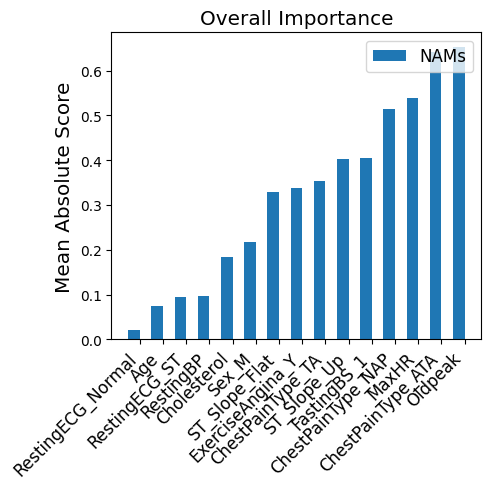

In [83]:
fig = plot_mean_feature_importance(litmodel.model, dataset)

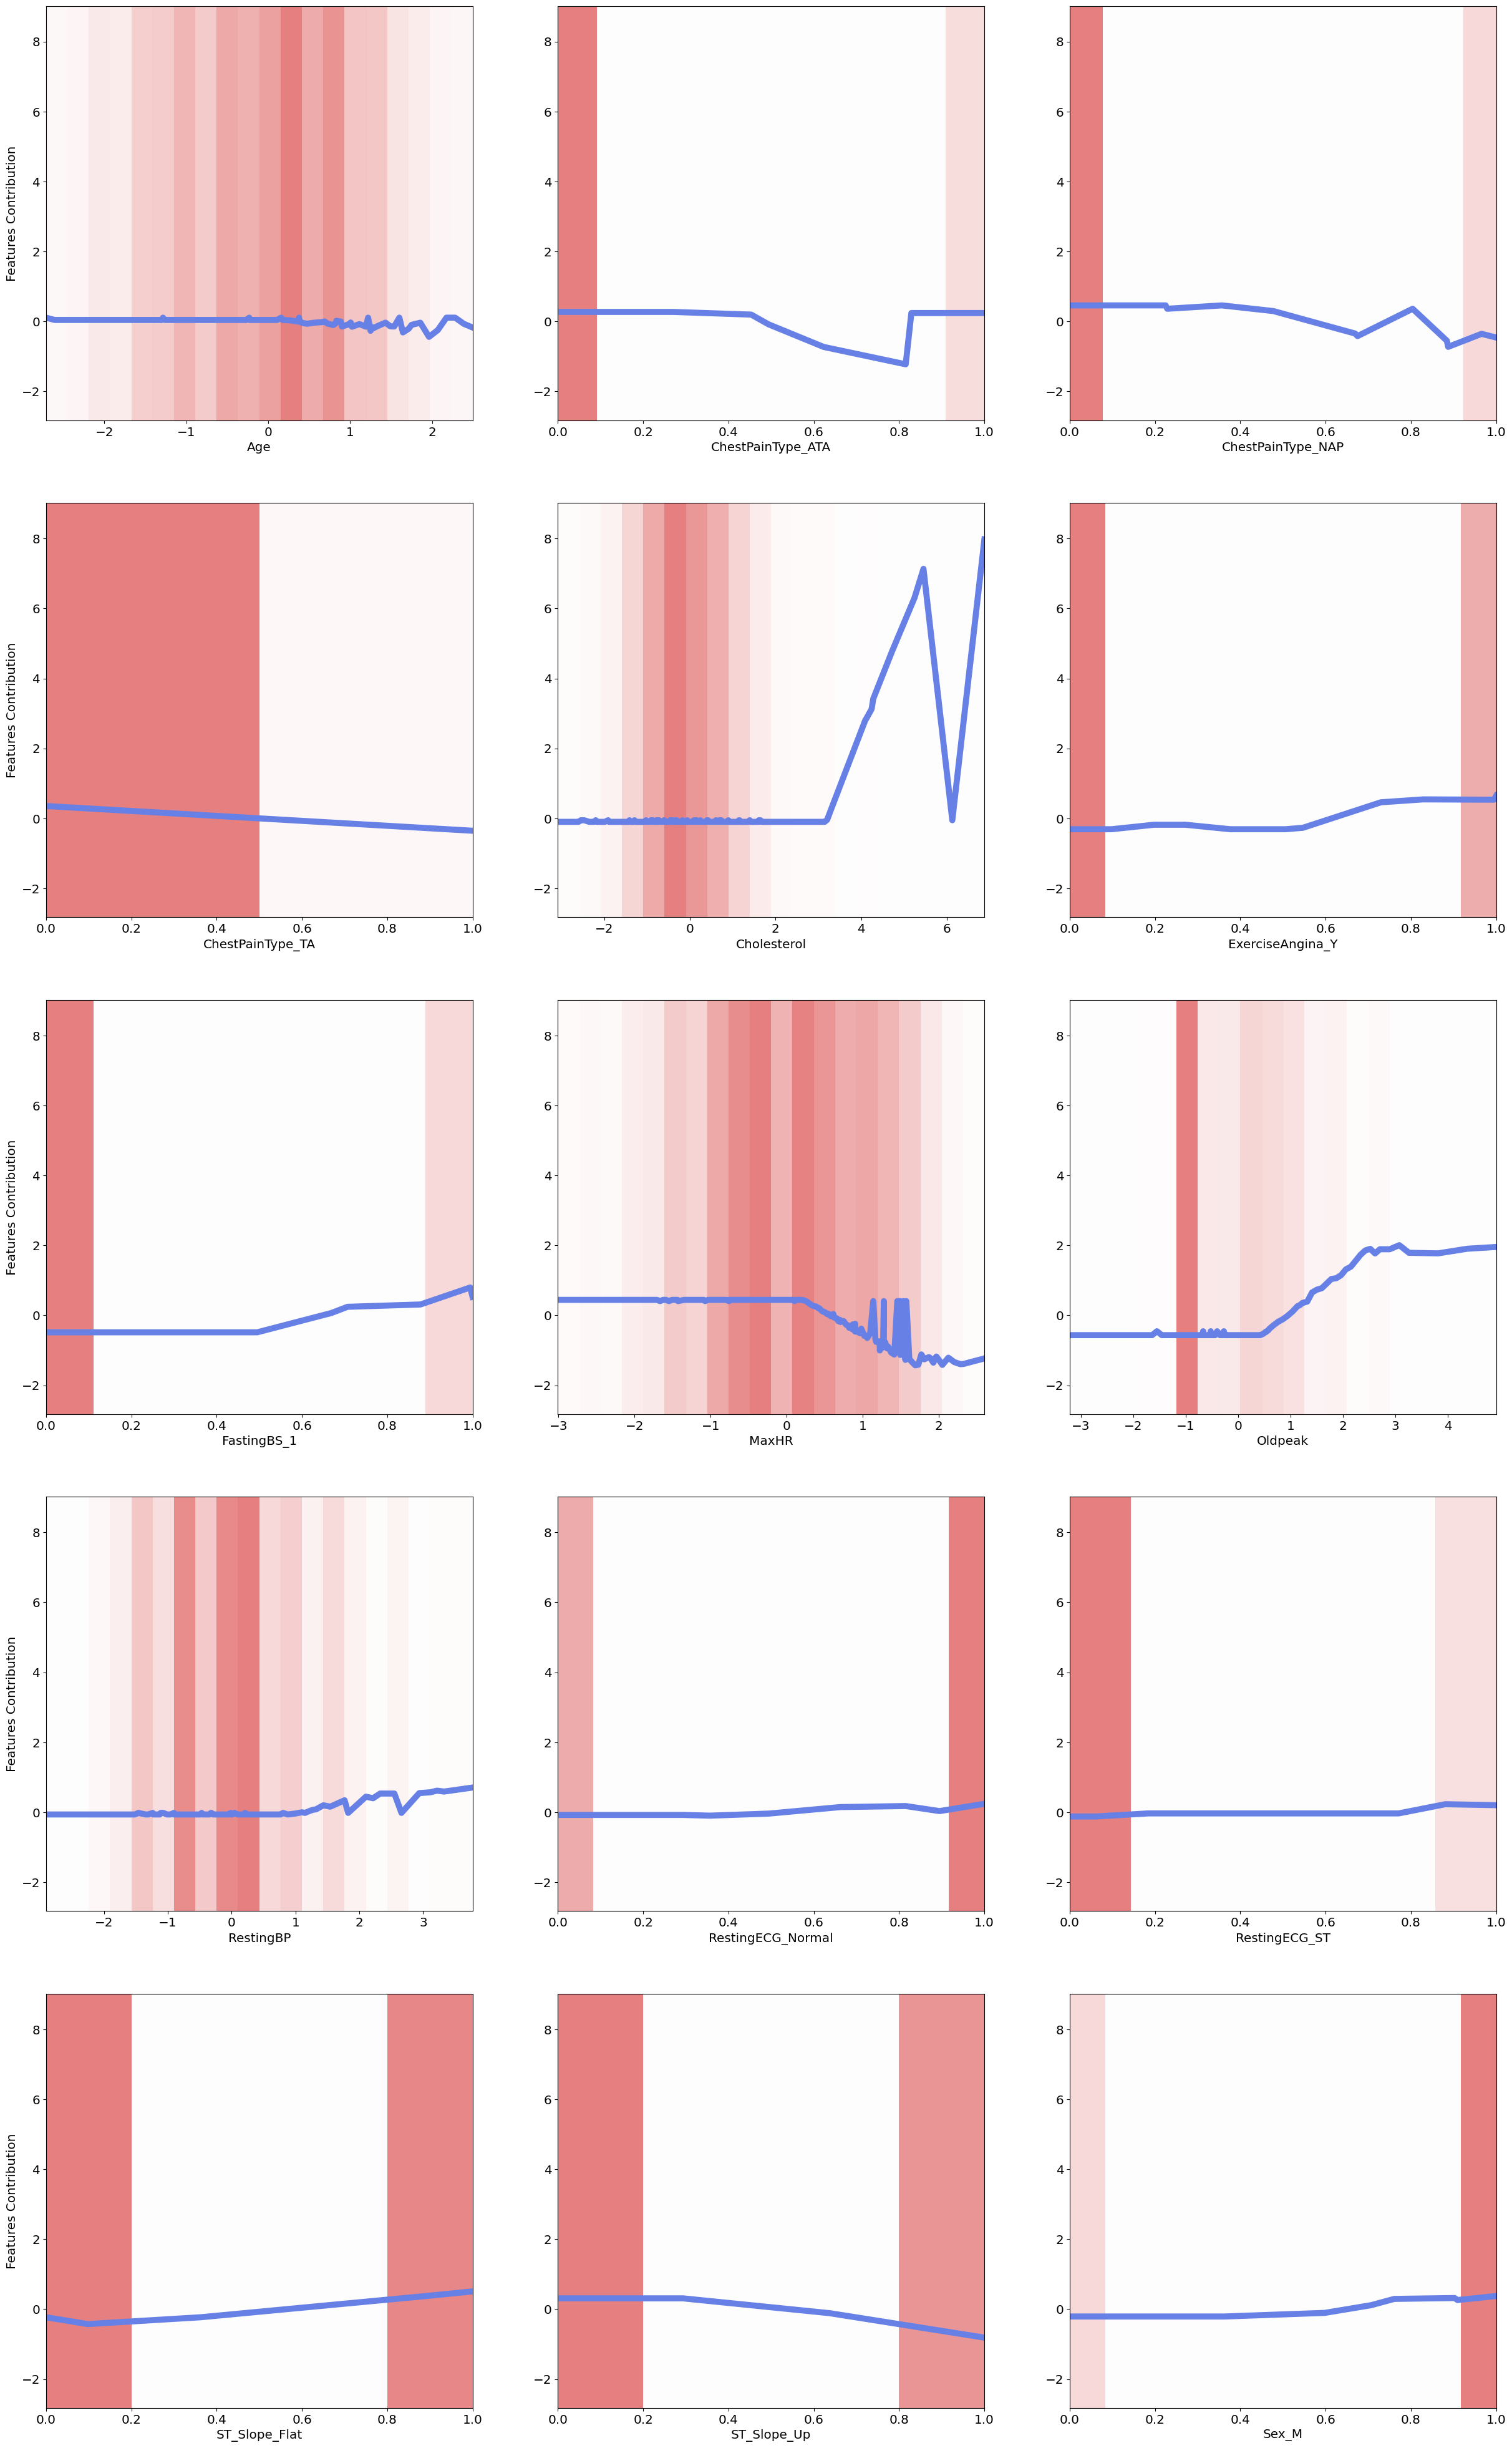

In [87]:
fig = plot_nams(litmodel.model, dataset, num_cols= 3)